# Description

This is documentation and scripts for the work *Scielo as a Scientometric research tool*. 

The steps and scripts following aim at reproducibility, however they should include access to the commercial databases Scopus, Dimensions and Web of Science. Also, they need access to a working implementation of OpenAlex.

- [Scopus](scopus.com) 
- [Dimensions](dimensions.ai)
- [Web of Science](webofscience.com)
- [OpenAlex](openalex.org)

All the steps can be implemented in a Google Big Query account. Other data warehouses can be used, with corresponding changes in the SQL scripts and import export step must also be adapted.

The version hereafter presented applies to a situation in which the commercial databases are external and imported to our Big Query account through CSV files. The commercial databases are queried to create theses tables with scripts here provided.



# Preparation

Steps to load Python modules and authentication.

- Check the project name in the follwing scripts.
- Check your access to Google Big Query using your google account.

If you are running this scripts inside the Google Colab Environment, the following snippets will provide access to your Google credentials in order to access Google Big Query. You should check if you have a Billing account to run the queries and that you have configured a project. By sure to access Big Query for the first time and follow instructions to check it. Also, change the project name in the cells for yours.

If you have no experience in Google Big Query, read:
(https://cloud.google.com/bigquery/docs/introduction).

The platform is accessible at
(https://cloud.google.com/bigquery).

If you want to have an introduction on how Google Colab notebooks interact with Big Query, see:
(https://colab.research.google.com/notebooks/bigquery.ipynb)

It also possible to run queries in Big Query from you local computer, preferably using an Anaconda Distribution installation (), to that effect, you should install and configure Google CLI (command-line-interface). The following instructions are made for that:

- Google CLI
https://cloud.google.com/cli?hl=pt-br
- Google Authentication
https://cloud.google.com/docs/authentication/provide-credentials-adc?hl=pt-br



In [ ]:
# Only if you are running in Colab. For locally running, follow instructions on 
# local instalation of Python, Google Authentication.

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# Python modules

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract information from Scielo

- Check access to our public dataset
[InSySPo Scielo database](https://console.cloud.google.com/bigquery?project=insyspo&ws=!1m19!1m4!1m3!1sinsyspo!2sbquxjob_e97f491_1872e34fd8d!3sUS!1m4!4m3!1sinsyspo!2sprojectdb_scielo_rm!3sworks_fjs!1m4!4m3!1sinsyspo!2sprojectdb_scielo_rm!3sworks_json!1m3!3m2!1sinsyspo!2spublicdb_scielo&pli=1&authuser=3).
- Check if you are part of a project or create one yourself (https://cloud.google.com/resource-manager/docs/creating-managing-projects?hl=pt-br).
- Create a dataset for your use, as instructed here (https://cloud.google.com/bigquery/docs/datasets?hl=pt-br#console). In our scripts, we have used a dataset named `projectdb_scielo_scientometric_tool`. 
- Collect IDs DOIs and publication year into a new table.
- From the table, count distinct IDs and distinct DOIs.

We have collected all the data from Scielo from a recent dump as a compacted files. Extracted it made into a public dataset inside Big Query so everyone can access it. 

We encourage to check the link, see the table and even query it if you have some SQL experience.

In the following we provide the scripts to collect the table we need.

## About Big Query statements

When creating tables, we sometines add a DROP TABLE statemente before. It only makes sense when rerunning to update the original table. In a very first execution you should not use this statement.

Know that tables are adressed as `project.dataset.table` or `dataset.table` when project is default or infered from environment.

When adressing table inside Big Query, one can put the name inside grave accents `like.this` ou simply type the name. The symbol ` allows calling names with non-latin alphabets, accents and spaces. Names in latin alphabet without accents and spaces do not need that.

# Scielo metadata as a dump

Compressed file with most of Scielo metadata:

 http://static.scielo.org/articlemeta/scielo_articles.zip 

## Table with raw JSON

In [ ]:
# Cleaning - Symbols @ and # inherited from the conversion to JSON are erased into a new table.
# Remember to change project name and dataset name.
# When creating tables, we sometines add a DROP TABLE statemente before. It only
# makes sense when rerunning to update the original table. In a very first execution
# you should not use this statement.
%%bigquery --project=insyspo

# DROP TABLE insyspo.projectdb_scielo_scientometric_tool.works_json;
CREATE TABLE projectdb_scielo_scientometric_tool.works_json AS (
  SELECT  REPLACE(
            REPLACE(work, '#', '')
          , '@','') AS work
FROM publicdb_scielo.scielo_works);


Query is running:   0%|          |

""


## Extract metadata

- Scielo identifier - id
- DOI - doi
- Publication year - pub_year


In [ ]:
%%bigquery --project=insyspo

# DROP TABLE projectdb_scielo_scientometric_tool.works;
CREATE TABLE projectdb_scielo_scientometric_tool.works AS (
SELECT  TRIM(COALESCE( # several fields have been used to store the id.
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.unique-article-id.text'), 
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.article-id[0].text'),
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.article-id.text')  
        ),'"') AS id,
        TRIM(JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.article-id[1].text'),'"') AS doi,
        CAST(TRIM(JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.pub-date.year'),'"') AS INT) AS pub_year,
FROM projectdb_scielo_scientometric_tool.works_json
);


Executing query with job ID: 805ddc12-4714-4f01-95b9-84e95965d840
Query executing: 0.65s


ERROR:
 409 Already Exists: Table insyspo:projectdb_scielo_scientometric_tool.works

Location: US
Job ID: 805ddc12-4714-4f01-95b9-84e95965d840



## Size statistics

In [ ]:
%%bigquery --project=insyspo

SELECT COUNT(doi) AS dois, 
    COUNT(DISTINCT(doi)) AS distinct_dois, 
    COUNT(DISTINCT(id)) AS distinct_ids,
    COUNT(*) AS total
FROM projectdb_scielo_scientometric_tool.works

Query is running:   0%|          |

Downloading:   0%|          |

,dois,distinct_dois,distinct_ids,total
0,729310,691206,1025115,1061736


## Trends in Scielo

In [ ]:
# Export yearly production to a Pandas dataframe.
%%bigquery df --project=insyspo

SELECT pub_year AS year,
    COUNT(DISTINCT(doi)) AS distinct_dois, 
    COUNT(DISTINCT(id)) AS distinct_ids,
FROM projectdb_scielo_scientometric_tool.works
WHERE pub_year IS NOT NULL
GROUP BY pub_year
ORDER BY pub_year ASC


Query is running:   0%|          |

Downloading:   0%|          |

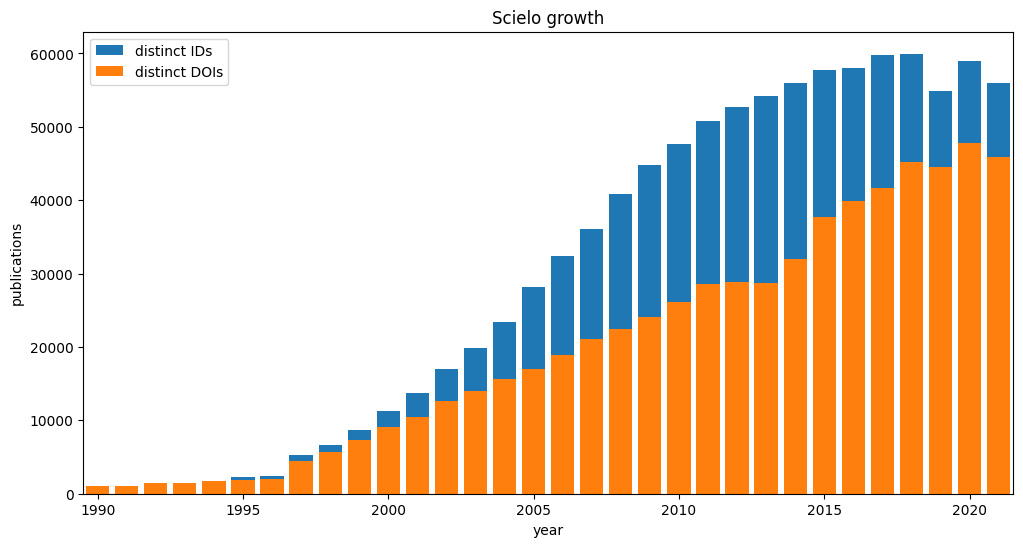

In [ ]:
x = df['year'].values
dois = df['distinct_dois'].values
ids = df['distinct_ids'].values

plt.figure(figsize=(12,6))
plt.bar(x,ids)
plt.bar(x,dois)
plt.xlim([1989.5,2021.5])
plt.title('Scielo growth')
plt.ylabel('publications')
plt.xlabel('year')
plt.legend(['distinct IDs','distinct DOIs'])

# Collections in Scielo

In [ ]:
%%bigquery collections --project=insyspo

SELECT TRIM(collection,'"') AS collection, COUNT(doi) AS ndoi, COUNT(id) AS n, COUNT(doi)/COUNT(id) AS p
FROM `insyspo.projectdb_scielo_rm.works_fjs`
GROUP BY collection
HAVING n>0
ORDER BY n DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
collections

,collection,ndoi,n,p
0,SciELO Brazil,472003,477971,0.987514
1,SciELO Colombia,44291,94325,0.469557
2,SciELO Mexico,29647,87625,0.338340
3,SciELO Chile,64101,81311,0.788344
4,SciELO Argentina,6905,51875,0.133108
5,SciELO Public Health,44247,50383,0.878213
6,SciELO Spain,19170,46480,0.412435
7,SciELO Cuba,111,43759,0.002537
8,SciELO South Africa,21318,37078,0.574950
9,SciELO Portugal,10582,25813,0.409948


<Axes: >

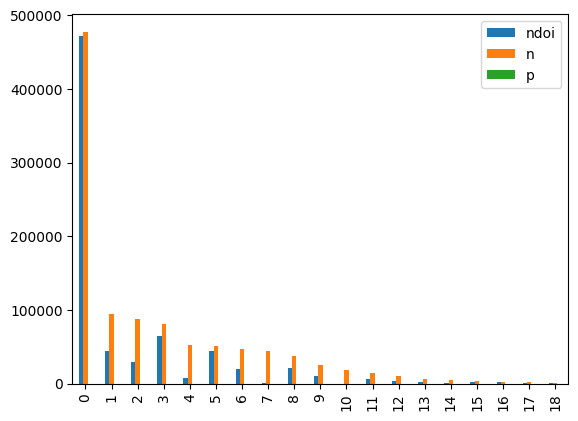

In [ ]:
x = collections['collection']
y = collections['n']
z = collections['ndoi']

# Match works from Scielo into other databases

- Using DOIs, it is possible to match the works present in Scielo inside other databases.
- The code to match the DOIs is run with access to commercial databases. It is included here for documentation purposes and it cannot run inside the notebook. It was written in Microsoft SQL server, so the sintax is slightly different. 

## Export Scielo table to be used externally

In [ ]:
%%bigquery df --project=insyspo

SELECT doi, MIN(pub_year)
FROM projectdb_scielo_scientometric_tool.works
WHERE doi IS NOT NULL
GROUP BY doi

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
from google.colab import files

df.to_csv('dois_scielo.csv') 
files.download('dois_scielo.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Scripts to query commercial databases

The previously saved table is imported into a Microsoft SQL server table as `userdb_alyssonafm.dbo.dois_scielo`.

In [ ]:
# The %%bigquey statement is here solely for sintax highlighting.
%%bigquery
SELECT COUNT(DISTINCT(b.doi))
  FROM [userdb_alyssonafm].[dbo].[dois_scielo] AS a
  LEFT JOIN dimensions_2022jun.dbo.pub AS b
  ON a.doi = b.doi

  /*  658234 */

 SELECT COUNT(DISTINCT(b.doi))
FROM userdb_alyssonafm.dbo.dois_scielo AS a
LEFT JOIN wos_2213.dbo.pub AS b
ON a.doi = b.doi

/* 224653 */

SELECT COUNT(DISTINCT(b.doi))
FROM userdb_alyssonafm.dbo.dois_scielo AS a
LEFT JOIN scopus_2022apr.dbo.pub AS b
ON a.doi = b.doi

/* 396405 */


/*** period 2017-2021 ***/
SELECT COUNT(DISTINCT(b.doi))
  FROM [userdb_alyssonafm].[dbo].[dois_scielo] AS a
  LEFT JOIN dimensions_2022jun.dbo.pub AS b
  ON a.doi = b.doi
  WHERE a.year >=2017 AND a.year <=2021

  /* 214002 */

 SELECT COUNT(DISTINCT(b.doi))
FROM userdb_alyssonafm.dbo.dois_scielo AS a
LEFT JOIN wos_2213.dbo.pub AS b
ON a.doi = b.doi
WHERE a.year >=2017 AND a.year <=2021
/* 75127 */

SELECT COUNT(DISTINCT(b.doi))
FROM userdb_alyssonafm.dbo.dois_scielo AS a
LEFT JOIN scopus_2022apr.dbo.pub AS b
ON a.doi = b.doi
WHERE a.year >=2017 AND a.year <=2021
/* 144611 */

/** trend analysis **/
 
 SELECT a.year, 
 COUNT(DISTINCT(b.doi)) AS dimensions,
 COUNT(DISTINCT(c.doi)) AS wos,
 COUNT(DISTINCT(d.doi)) AS scopus
INTO userdb_alyssonafm.dbo.trend_scielo_others
FROM userdb_alyssonafm.dbo.dois_scielo AS a
  LEFT JOIN dimensions_2022jun.dbo.pub AS b
  ON a.doi = b.doi
LEFT JOIN wos_2213.dbo.pub AS c
ON a.doi = c.doi
LEFT JOIN scopus_2022apr.dbo.pub AS d
ON a.doi = d.doi
GROUP BY a.year
# The output is in the table trend_scielo_others, that is saved to a csv file.

The output exported to a csv file must be imported here. It can be done using Google drive folder. For our purposes, the table is given as a public link. 


In [ ]:
from google.colab import drive # erase this for github!
drive.mount('/content/drive/')
folder = '/content/drive/My Drive/Colaboração/Scielo/'

Mounted at /content/drive/


In [ ]:
# T = pd.read_csv(folder+'trend_scielo_others.csv',encoding='utf-16') replace with public link!!!
commercial_db = pd.read_csv(folder+'trend_scielo_others.csv',encoding='utf-16')
commercial_db = commercial_db.dropna()
commercial_db = commercial_db.astype({'year':int})

## OpenAlex

We have used a verion of OpenAlex updated up to April 2022 that is available as a public dataset in the link (https://console.cloud.google.com/bigquery?project=insyspo&ws=!1m4!1m3!3m2!1sinsyspo!2spublicdb_openalex_2022_04&pli=1).

In [ ]:
%%bigquery openalex_db --project=insyspo

SELECT pub_year AS year,
    COUNT(DISTINCT(b.doi)) AS openalex,
    COUNT(DISTINCT(a.doi)) AS scielo,
    COUNT(DISTINCT(a.id)) AS total_scielo
FROM insyspo.projectdb_scielo_scientometric_tool.works AS a
LEFT JOIN insyspo.publicdb_openalex_2022_04.works AS b
ON LOWER(SUBSTR(b.doi,17)) = LOWER(a.doi)
WHERE pub_year IS NOT NULL
GROUP BY a.pub_year
ORDER BY a.pub_year ASC

Query is running:   0%|          |

Downloading:   0%|          |

## Comparison of presence of Scielo works in different databases


### Number of works

Text(0.5, 1.0, 'Works in Scielo each year')

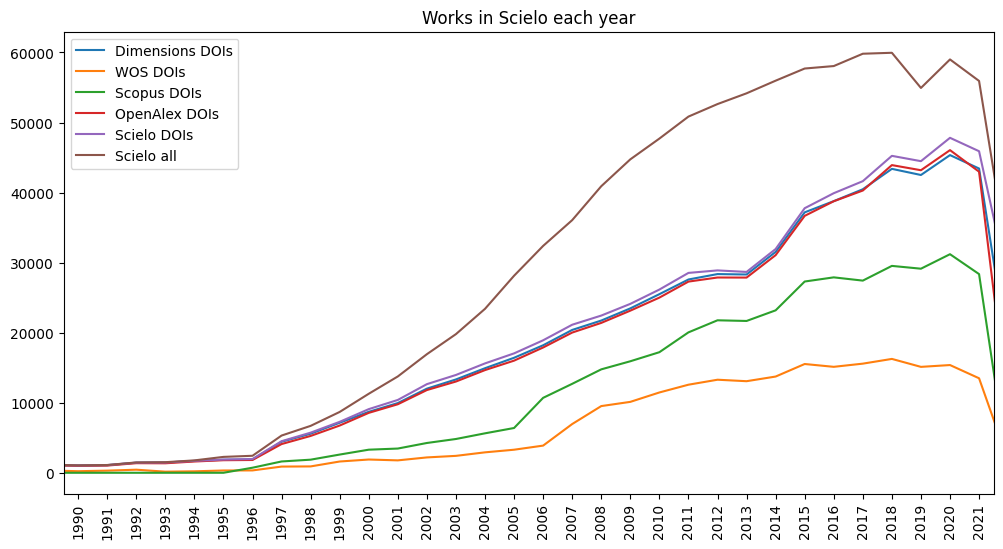

In [ ]:
x = commercial_db['year'].values
y1 = commercial_db['dimensions'].values
y2 = commercial_db['wos'].values
y3 = commercial_db['scopus'].values

x2 = openalex_db['year'].values
y4 = openalex_db['openalex'].values
y5 = openalex_db['scielo'].values
y6 = openalex_db['total_scielo'].values

plt.figure(figsize=(12,6))
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)
plt.plot(x,y5)
plt.plot(x,y6)
plt.xticks(rotation=90)
plt.xlim([1989.5,2021.5])
plt.locator_params(axis='x', nbins=40)
plt.legend(['Dimensions DOIs','WOS DOIs','Scopus DOIs','OpenAlex DOIs',
            'Scielo DOIs','Scielo all'])
plt.title('Works in Scielo each year')

### Proportion of works

Text(0.5, 1.0, 'Presence of Scielo DOIs each year')

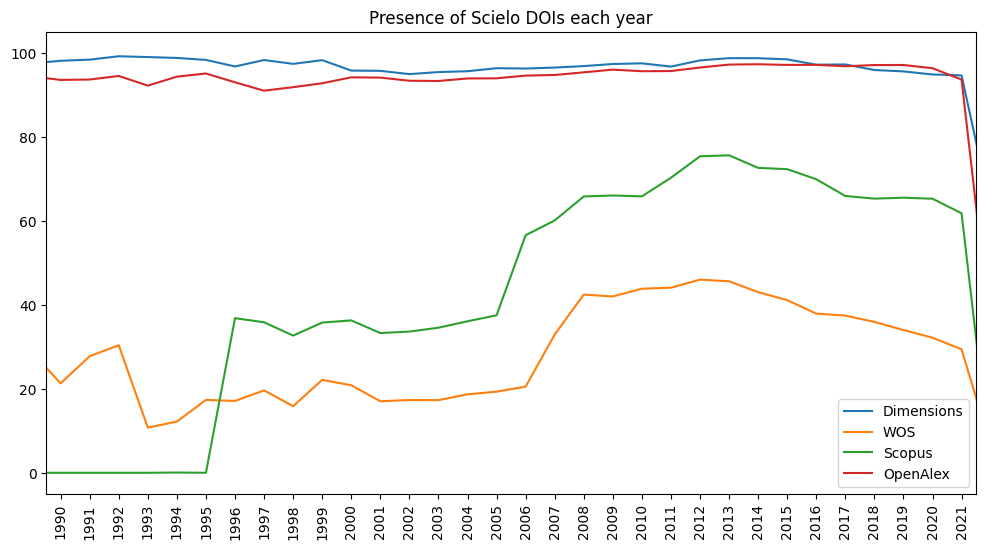

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(x,100*y1/y5)
plt.plot(x,100*y2/y5)
plt.plot(x,100*y3/y5)
plt.plot(x,100*y4/y5)
plt.xticks(rotation=90)
plt.xlim([1989.5,2021.5])
plt.locator_params(axis='x', nbins=40)
plt.legend(['Dimensions','WOS','Scopus','OpenAlex'])
plt.title('Presence of Scielo DOIs each year')

## Brazilian works inside Scielo

Another approach is to study the brazilian works inside Scielo which as also present in commercial databases. It is a good indication of Scielo trends given that it is its largest subset.

The script to collect the number of Scielo works with brazilian authors in commercial databases is given bellow.

## BR Scielo in Commercial databases

In [ ]:
%%bigquery

/** Dimensions **/
drop table #BR_DOI_Dimensions_aly
SELECT distinct [country_code], b.doi, b.pub_year
into #BR_DOI_Dimensions_aly
  FROM [dimensions_2022jun].[dbo].[pub_affiliation_country] as a
  join [dimensions_2022jun].[dbo].[pub] as b on a.pub_id=b.pub_id
  where country_code='BR' and b.doi is not null
--1,511,276 [02:52]

drop table #BR_DOI_Dimensions_scielo_match_aly
select DISTINCT a.*, case when b.doi is not null then 1 else 0 end as p_doi_scielo
into #BR_DOI_Dimensions_scielo_match_aly
from #BR_DOI_Dimensions_aly as a
left join [userdb_alyssonafm].[dbo].[dois_scielo] as b on a.doi=b.doi
--1,511,276

select country_code, 
	count(doi) as p, 
	sum(p_doi_scielo) as p_dois_scielo, 
	sum(p_doi_scielo)/cast(count(doi) as float) as pp_doi_scielo
from #BR_DOI_Dimensions_scielo_match_aly
group by country_code

select country_code, 
	count(doi) as p, 
	sum(p_doi_scielo) as p_dois_scielo, 
	sum(p_doi_scielo)/cast(count(doi) as float) as pp_doi_scielo
from #BR_DOI_Dimensions_scielo_match_aly
where pub_year between 2017 and 2021
group by country_code

drop table userdb_alyssonafm.dbo.dimensions_scielo
select country_code, 
	pub_year, count(doi) as p, 
	sum(p_doi_scielo) as p_dois_scielo, 
	sum(p_doi_scielo)/cast(count(doi) as float) as pp_doi_scielo
into userdb_alyssonafm.dbo.dimensions_scielo
from #BR_DOI_Dimensions_scielo_match_aly
--where pub_year between 1990 and 2021
group by country_code, pub_year
order by country_code, pub_year

/** Scopus **/
drop table #BR_DOI_Scopus_aly
SELECT distinct a.country_iso_alpha3_code AS country_code, b.doi, b.pub_year
into #BR_DOI_Scopus_aly
  FROM [scopus_2022apr].[dbo].pub_affiliation as a
  join scopus_2022apr.[dbo].[pub] as b on a.eid=b.eid
  where country_iso_alpha3_code='bra' and b.doi is not null
--1100430

drop table #BR_DOI_Scopus_scielo_match_aly
select DISTINCT a.*, case when b.doi is not null then 1 else 0 end as p_doi_scielo
into #BR_DOI_Scopus_scielo_match_aly
from #BR_DOI_Scopus_aly as a
left join [userdb_alyssonafm].[dbo].[dois_scielo] as b on a.doi=b.doi
--1100430

drop table userdb_alyssonafm.dbo.scopus_scielo
select country_code, 
	pub_year, count(doi) as p, 
	sum(p_doi_scielo) as p_dois_scielo, 
	sum(p_doi_scielo)/cast(count(doi) as float) as pp_doi_scielo
into userdb_alyssonafm.dbo.scopus_scielo
from #BR_DOI_Scopus_scielo_match_aly
--where pub_year between 1990 and 2021
group by country_code, pub_year
order by country_code, pub_year

/** WOS **/

drop table #BR_DOI_WOS_aly
SELECT distinct c.country_iso_alpha3_code AS country_code, b.doi, b.pub_year
into #BR_DOI_WOS_aly
  FROM wos_2213.[dbo].pub_affiliation as a
  join [wos_2213].dbo.[pub] as b on a.ut= b.ut
  JOIN wos_2213.[dbo].country as c on a.country_id = c.country_id
  where c.country_iso_alpha3_code='BRA' and b.doi is not null
--856217

drop table #BR_DOI_WOS_scielo_match_aly
select DISTINCT a.*, case when b.doi is not null then 1 else 0 end as p_doi_scielo
into #BR_DOI_WOS_scielo_match_aly
from #BR_DOI_WOS_aly as a
left join [userdb_alyssonafm].[dbo].[dois_scielo] as b on a.doi=b.doi
--856217


drop table userdb_alyssonafm.dbo.wos_scielo
select country_code, 
	pub_year, count(doi) as p, 
	sum(p_doi_scielo) as p_dois_scielo, 
	sum(p_doi_scielo)/cast(count(doi) as float) as pp_doi_scielo
into userdb_alyssonafm.dbo.wos_scielo
from #BR_DOI_WOS_scielo_match_aly
group by country_code, pub_year
order by country_code, pub_year

/** Collect all **/
--DROP TABLE userdb_alyssonafm.dbo.scielo_others_br
SELECT a.pub_year, 
	a.p AS dimensions,
	b.p AS scopus,
	c.p AS wos,
	a.p_dois_scielo AS scielo_dimensions,
	b.p_dois_scielo AS scielo_scopus,
	c.p_dois_scielo AS scielo_wos
into userdb_alyssonafm.dbo.scielo_others_br
FROM userdb_alyssonafm.dbo.dimensions_scielo AS a
LEFT JOIN userdb_alyssonafm.dbo.scopus_scielo AS b
ON a.pub_year = b.pub_year
LEFT JOIN userdb_alyssonafm.dbo.wos_scielo AS c
ON a.pub_year = c.pub_year AND a.pub_year IS NOT NULL
ORDER BY pub_year ASC

# The output is in the table scielo_other_br

In [ ]:
BR_commercial_db = pd.read_csv(folder+'scielo_others_br.csv',encoding='utf-16')
BR_commercial_db = BR_commercial_db.sort_values(by='pub_year')

NameError: ignored

### BR Scielo in OpenAlex

In [ ]:
%%bigquery BR_openalex_db --project=insyspo

SELECT a.publication_year AS pub_year,
  COUNT(DISTINCT(a.doi)) AS openalex,
  COUNT(DISTINCT(d.doi)) AS scielo  
FROM insyspo.publicdb_openalex_2022_04.works AS a
JOIN insyspo.publicdb_openalex_2022_04.works_authorships AS b
ON a.id = b.work_id
JOIN insyspo.publicdb_openalex_2022_04.institutions AS c
ON c.id = b.institution_id
LEFT JOIN insyspo.projectdb_scielo_scientometric_tool.works AS d
ON d.doi = SUBSTR(a.doi,17)
WHERE c.country_code = 'BR'
GROUP BY pub_year
ORDER BY pub_year aSC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
BR_openalex_db = BR_openalex_db.dropna()


### BR Scielo in comparison

In [ ]:
x = BR_commercial_db['pub_year'].values
y1 = BR_commercial_db['dimensions'].values
y2 = BR_commercial_db['wos'].values
y3 = BR_commercial_db['scopus'].values
y4 = BR_commercial_db['scielo_dimensions'].values
y5 = BR_commercial_db['scielo_wos'].values
y6 = BR_commercial_db['scielo_scopus'].values

x2 = BR_openalex_db['pub_year'].astype(int).values
y7 = BR_openalex_db['openalex'].values
y8 = BR_openalex_db['scielo'].values




In [ ]:
tind = np.logical_and(x>1989, x<2022) 
x = x[tind]
y1 = y1[tind]
y2 = y2[tind]
y3 = y3[tind]
y4 = y4[tind]
y5 = y5[tind]
y6 = y6[tind]

tind = np.logical_and(x2>1989, x2<2022) 
x2 = x2[tind]
y7 = y7[tind]
y8 = y8[tind]


<Figure size 1200x600 with 0 Axes>

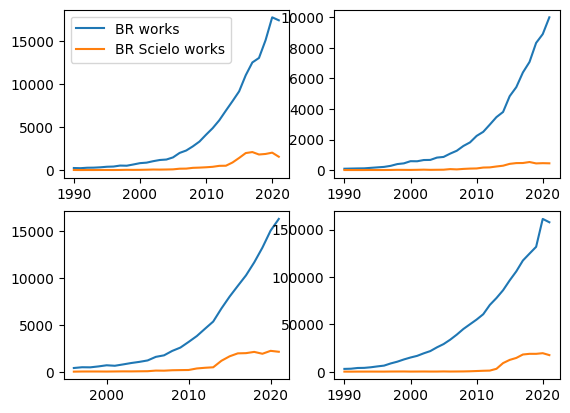

In [ ]:
plt.figure(figsize=(12,6))
fig, axs = plt.subplots(2,2)

axs[0,0].plot(x,y1)
axs[0,0].plot(x,y4)
axs[0,0].legend(['BR works','BR Scielo works'])

axs[0,1].plot(x,y2)
axs[0,1].plot(x,y5)

axs[1,0].plot(x,y3)
axs[1,0].plot(x,y6)

axs[1,1].plot(x2,y7)
axs[1,1].plot(x2,y8)


Text(0.5, 1.0, 'OpenAlex')

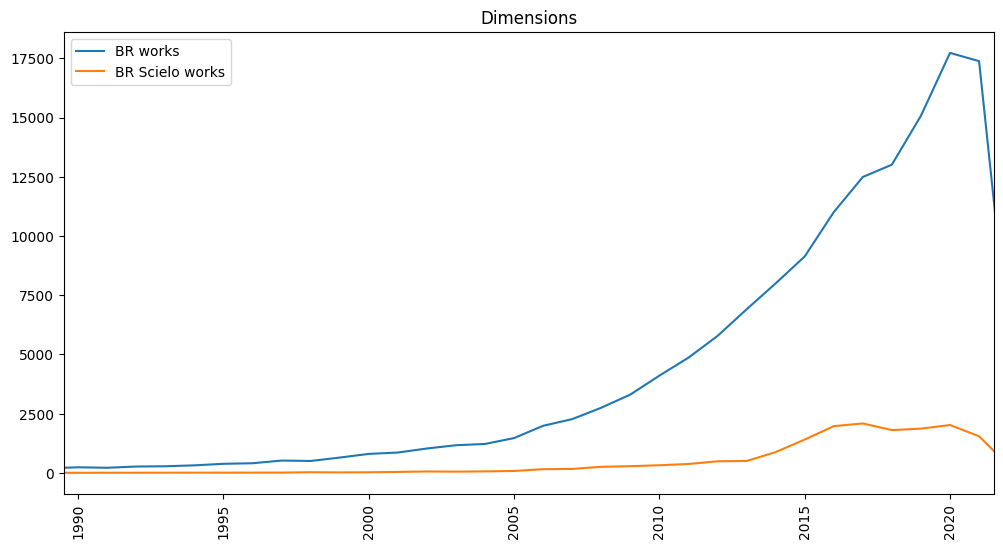

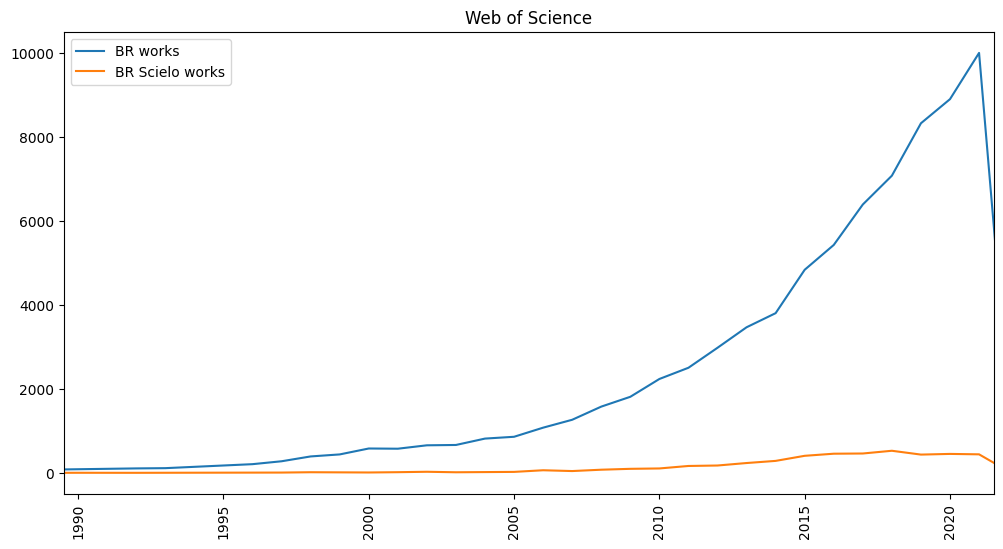

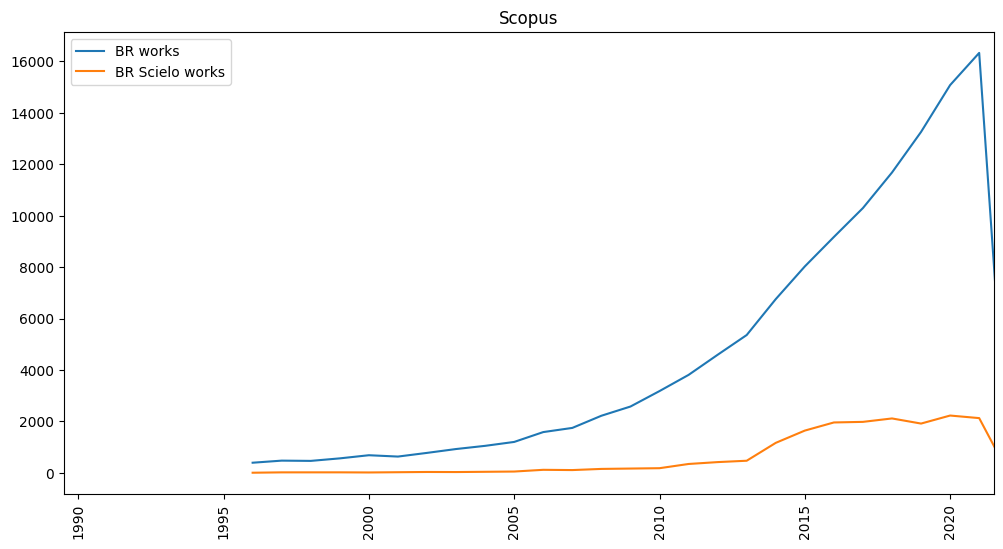

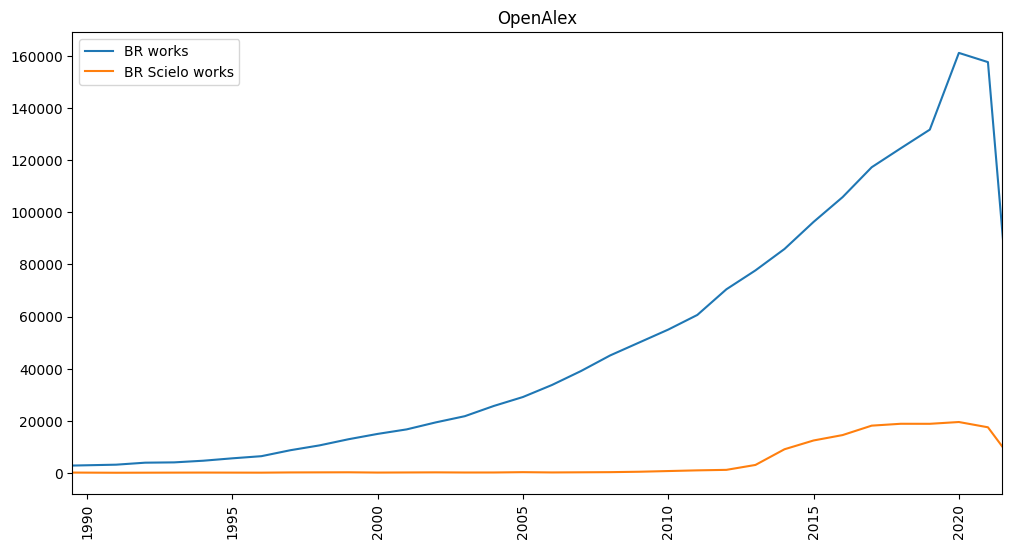

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(x,y1)
plt.plot(x,y4)
plt.xticks(rotation=90)
plt.xlim([1989.5,2021.5])
plt.legend(['BR works','BR Scielo works'])
plt.title('Dimensions')

plt.figure(figsize=(12,6))
plt.plot(x,y2)
plt.plot(x,y5)
plt.xticks(rotation=90)
plt.xlim([1989.5,2021.5])
plt.legend(['BR works','BR Scielo works'])
plt.title('Web of Science')

plt.figure(figsize=(12,6))
plt.plot(x,y3)
plt.plot(x,y6)
plt.xticks(rotation=90)
plt.xlim([1989.5,2021.5])
plt.legend(['BR works','BR Scielo works'])
plt.title('Scopus')

plt.figure(figsize=(12,6))
plt.plot(x2,y7)
plt.plot(x2,y8)
plt.xticks(rotation=90)
plt.xlim([1989.5,2021.5])
plt.legend(['BR works','BR Scielo works'])
plt.title('OpenAlex')

# Subject analysis

Using Dimensions subjects, it is possible to explore the nature of works, since this database covers most of it.

Scripts to collect the Dimensions subjects from the Scielo works as presented bellow.

In [ ]:
%%bigquery

drop table #BR_DOI_Dimensions
SELECT distinct [country_code], b.doi, b.pub_year, b.pub_id
into #BR_DOI_Dimensions
  FROM [dimensions_2022jun].[dbo].[pub_affiliation_country] as a
  join [dimensions_2022jun].[dbo].[pub] as b on a.pub_id=b.pub_id
  where country_code='BR' and b.doi is not null
  and pub_year between 1990 and 2021
--1428491 [04:21]


-- final datasetdrop table #pubs
drop table #pubs
select DISTINCT a.*
, case when b.doi is not null then 1 else 0 end as p_doi_scielo
, case when c.doi is not null then 1 else 0 end as p_doi_wos
into #pubs
from #BR_DOI_Dimensions as a
left join [userdb_alyssonafm].[dbo].[dois_scielo] as b on a.doi=b.doi
left join wos_2213.dbo.pub_detail as c on a.doi=c.doi
--1428491

--General value
select count(pub_id) as p, sum(p_doi_scielo) as p_scielo, sum(p_doi_scielo)/cast(count(pub_id) as float) as pp_scielo
from #pubs

--FOR_Groups
drop table #pubs_for_group
select distinct a.country_code, c.for_group, c.for_group_id, a.pub_id, a.p_doi_scielo, a.p_doi_wos
, case when a.p_doi_wos=1 and a.p_doi_scielo=0 then 1 else 0 end as p_only_wos --This is for later use
into #pubs_for_group
from #pubs as a
join [dimensions_2022jun].[dbo].pub_for_group as b on a.pub_id=b.pub_id
join [dimensions_2022jun].[dbo].[for_group] as c on b.for_group_id=c.for_group_id
----1420340
----select count(distinct pub_id) from #pubs_for_group
----1115824 distinc publications witha  for_group in dimensions

select a.country_code, a.for_group, a.for_group_id, count(pub_id) as p_dimensions, sum(p_doi_scielo) as p_scielo, count(pub_id)-sum(p_doi_scielo) as p_out_scielo
, sum(p_doi_scielo)/cast(count(pub_id) as float) as pp_scielo
, (sum(p_doi_scielo)/cast(count(pub_id) as float))/cast((select sum(p_doi_scielo)/cast(count(pub_id) as float) as pp_scielo_global from #pubs) as float) as ratio_scielo
from #pubs_for_group as a
group by a.country_code, a.for_group, a.for_group_id
having count(pub_id)>6000 
order by a.country_code,  count(pub_id) desc

-- Concepts
-- First, select the concept with the higest relevance per paer
drop table #step1
select a.pub_id, b.concept_id, b.relevance_score
into #step1
from #pubs as a
join [dimensions_2022jun].[dbo].[pub_concept] as b on a.pub_id=b.pub_id
where b.relevance_score>0.5
--15750824

drop table #step2
select pub_id, max(relevance_score) as max_relevance_score
into #step2
from #step1
group by pub_id
--821664

drop table #step3
select distinct a.*
into #step3
from #step1 as a
join #step2 as b on a.pub_id=b.pub_id and a.relevance_score=b.max_relevance_score
--837841

drop table #concepts_pubs
select c.concept, c.concept_id, a.pub_id, a.p_doi_scielo
into #concepts_pubs
from #pubs as a
join #step3 as b on a.pub_id=b.pub_id
join [dimensions_2022jun].[dbo].[concept] as c on b.concept_id=c.concept_id
--837841

select concept, concept_id, count(pub_id) as p_dimensions, sum(p_doi_scielo) as p_scielo 
, sum(p_doi_scielo)/cast(count(pub_id) as float) as pp_scielo
, (sum(p_doi_scielo)/cast(count(pub_id) as float))/cast((select sum(p_doi_scielo)/cast(count(pub_id) as float) as pp_scielo_global from #pubs) as float) as ratio_scielo
from #concepts_pubs
group by concept, concept_id
having count(pub_id)>200 and sum(p_doi_scielo)>10
order by count(pub_id) desc
---